In [2]:
import pandas as pd
import numpy as np


In [3]:
data = pd.read_csv('adults dataset preprocessed.csv')

In [4]:
data_import = pd.read_csv('adults.csv')
data_import

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## Data preprocessing 

In [5]:
data = data_import.copy()

### Label the columns

In [6]:
# create a new header
header = ["age", "workclass","fnlgt","education","education_num","marital_status","occupation","relationship","race","sex","capital_gain","capital_loss","hours_per_week","native_country","income"]

# Move old header row (which contains first data row) into dataframe
data.loc[-1] = data.columns.tolist()  # 
data.index = data.index + 1
data = data.sort_index().reset_index(drop=True)

# Assign the proper header names
data.columns = header


In [7]:
data["workclass"].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [8]:
data.columns

Index(['age', 'workclass', 'fnlgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')

In [9]:
data

,age,workclass,fnlgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


### Data cleaning 
remove "race" as a feature <br>
remove eductaon bec we have education_num<br>
label encode sex<br>
cahnge native_country to be "Immigrant" or "Non_Immigrant" and standard encode<br>
drop income and store in separate variable<br>
one hot encode = work_class | martial_status | occupation | relationship<br>
scale all values<br>

In [10]:
data_drop_race = data.copy() #deep copy as modifications will be made without affecting original data
data_drop_race = data_drop_race.drop(['education', 'race'],axis=1)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labedl_encode_sex = data_drop_race
labedl_encode_sex['sex'] = le.fit_transform(labedl_encode_sex['sex'])

native_country = labedl_encode_sex
native_country['native_country'] = native_country['native_country'].apply(lambda x: 0 if x == 'United-States' else 1)

y = native_country['income']

drop_incomes = native_country.drop(['income'],axis=1) 

one_hot_encode = pd.get_dummies(drop_incomes, columns = ['workclass', 'marital_status', 'occupation', 'relationship'], drop_first=False) #drop_first=True used with linear models to avoid dummy variable trap

#one_hot_encoded_data = pd.get_dummies(drop_incomes[['workclass', 'marital_status', 'occupation', 'relationship']], drop_first=False)
#numeric_data = drop_incomes.drop(columns=['workclass', 'marital_status', 'occupation', 'relationship'])
#combined = pd.concat([numeric_data, one_hot_encoded_data], axis=1)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(one_hot_encode)

cleaned_data = pd.DataFrame(scaled_data, columns=one_hot_encode.columns)



In [11]:
cleaned_data

,age,fnlgt,education_num,sex,capital_gain,capital_loss,hours_per_week,native_country,workclass_ ?,workclass_ Federal-gov,...,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife
0,0.030671,-1.063611,1.134739,0.703071,0.148453,-0.21666,-0.035429,0.0,-0.24445,-0.174295,...,-0.142608,-0.355316,-0.171279,-0.227104,-0.825333,1.708991,-0.17625,-0.429346,-0.344032,-0.224927
1,0.837109,-1.008707,1.134739,0.703071,-0.145920,-0.21666,-2.222153,0.0,-0.24445,-0.174295,...,-0.142608,-0.355316,-0.171279,-0.227104,1.211632,-0.585141,-0.17625,-0.429346,-0.344032,-0.224927
2,-0.042642,0.245079,-0.420060,0.703071,-0.145920,-0.21666,-0.035429,0.0,-0.24445,-0.174295,...,-0.142608,-0.355316,-0.171279,-0.227104,-0.825333,1.708991,-0.17625,-0.429346,-0.344032,-0.224927
3,1.057047,0.425801,-1.197459,0.703071,-0.145920,-0.21666,-0.035429,0.0,-0.24445,-0.174295,...,-0.142608,-0.355316,-0.171279,-0.227104,1.211632,-0.585141,-0.17625,-0.429346,-0.344032,-0.224927
4,-0.775768,1.408176,1.134739,-1.422331,-0.145920,-0.21666,-0.035429,0.0,-0.24445,-0.174295,...,-0.142608,-0.355316,-0.171279,-0.227104,-0.825333,-0.585141,-0.17625,-0.429346,-0.344032,4.445891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.849080,0.639741,0.746039,-1.422331,-0.145920,-0.21666,-0.197409,0.0,-0.24445,-0.174295,...,-0.142608,-0.355316,5.838432,-0.227104,-0.825333,-0.585141,-0.17625,-0.429346,-0.344032,4.445891
32557,0.103983,-0.335433,-0.420060,0.703071,-0.145920,-0.21666,-0.035429,0.0,-0.24445,-0.174295,...,-0.142608,-0.355316,-0.171279,-0.227104,1.211632,-0.585141,-0.17625,-0.429346,-0.344032,-0.224927
32558,1.423610,-0.358777,-0.420060,-1.422331,-0.145920,-0.21666,-0.035429,0.0,-0.24445,-0.174295,...,-0.142608,-0.355316,-0.171279,-0.227104,-0.825333,-0.585141,-0.17625,-0.429346,2.906704,-0.224927
32559,-1.215643,0.110960,-0.420060,0.703071,-0.145920,-0.21666,-1.655225,0.0,-0.24445,-0.174295,...,-0.142608,-0.355316,-0.171279,-0.227104,-0.825333,-0.585141,-0.17625,2.329125,-0.344032,-0.224927


## Modeling 

In [12]:
from sklearn.cluster import KMeans

k = 7 #the number of clusters that we want to find
kmeans = KMeans(n_clusters=k,random_state=42)

y_pred = kmeans.fit_predict(cleaned_data) #assign each instance to a group from 0-4, fit the model and predict the clusters
y_pred

#kmeans.cluster_centers_ #get the coordinates of the cluster centers

#kmeans.predict(X_test)#Assigns each test value to a cluster 


array([5, 2, 1, ..., 6, 5, 3], dtype=int32)

In [13]:
kmeans.inertia_ #sum of squared distances of samples to their closest cluster center, lower is better

1135456.8750687735

### Testsing the number of clusters 

In [14]:
from sklearn.metrics import silhouette_score

inertias = []
sil_scores = []

total_range = range (2,20) #starting from 2 as silhouette score is not defined for k=1 (cant work with one cluster)


for i in total_range:
    #k = i
    kmeans = KMeans(n_clusters=i,random_state=42)
    kmeans.fit(cleaned_data)

    sil_scores.append(silhouette_score(cleaned_data, kmeans.labels_))

    inertias.append(kmeans.inertia_)

In [15]:
pd.DataFrame(kmeans.labels_).value_counts() 

0 
7     4677
13    3398
2     2571
1     2542
16    2495
4     2078
5     2027
9     1836
17    1832
10    1541
8     1400
6     1363
15    1317
11     980
14     924
0      915
3      649
12       9
18       7
Name: count, dtype: int64

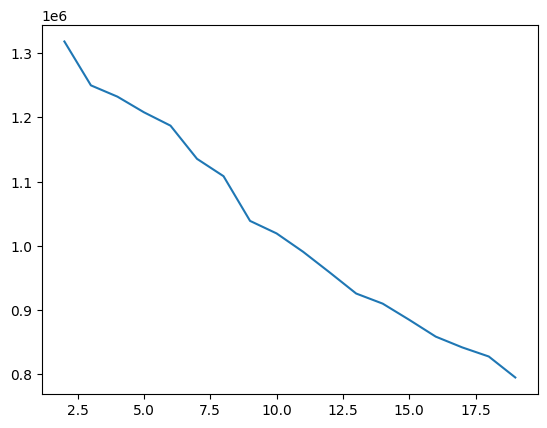

In [16]:
import matplotlib.pyplot as plt 

plt.plot(total_range,inertias)

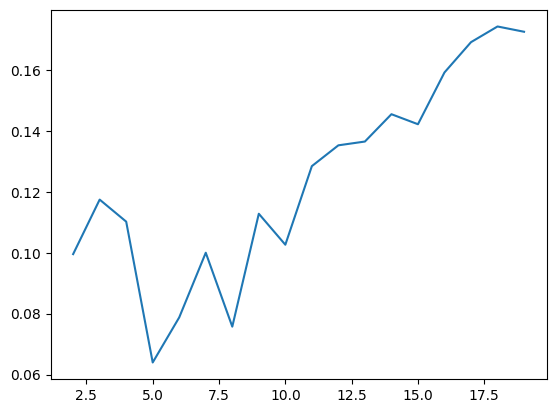

In [17]:
plt.plot(total_range,sil_scores)

In [18]:
kmeans = KMeans(n_clusters=9,random_state=42)
kmeans.fit(cleaned_data) #training (fitting) the K-Means algorithm on your dataset.

sil_scores.append(silhouette_score(cleaned_data, kmeans.labels_))  #kmeans.labels_ stores each point with its cluster

inertias.append(kmeans.inertia_)

In [19]:
y_pred = kmeans.fit_predict(cleaned_data)  # .fit() trains the KMeans model.
                                           #.predict() assigns each sample to its nearest cluster center.
y_pred

array([8, 7, 8, ..., 5, 4, 6], dtype=int32)

In [20]:
silhouette_score(cleaned_data, y_pred)

np.float64(0.11278244610382646)

### PCA

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(cleaned_data)
X2D


array([[-1.3151148 ,  0.90635172],
       [ 2.58188972,  1.15128292],
       [-1.22860522, -0.86778538],
       ...,
       [-1.61577975,  1.38207986],
       [-2.5919697 , -1.24642325],
       [ 1.64931133,  1.72295323]])

In [22]:
#pd.concat( [pd.DataFrame(data=X2D, columns=['X', 'Y']), pd.Series(y_pred, name = 'Cluster') ], axis =1).to_csv('clustering.csv', index= True)

In [23]:
x_points = []
y_points = []

for point in X2D:
    x_points.append(point[0])
    y_points.append(point[1])

c:\Users\AFRAAD-PC1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


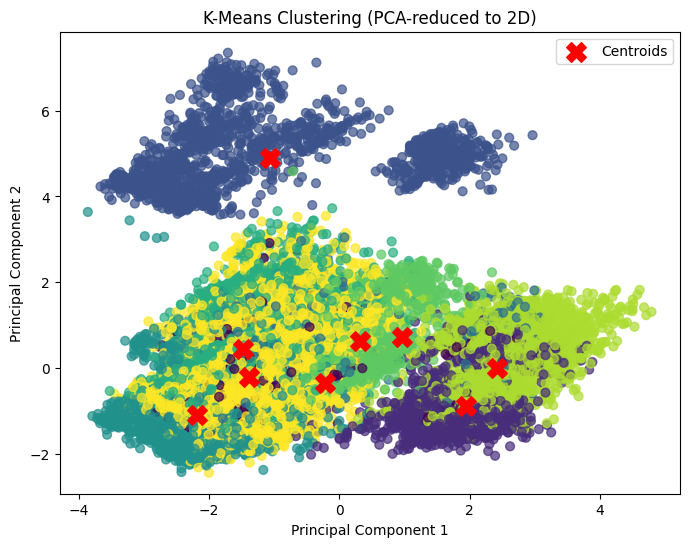

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(
    X2D[:, 0], X2D[:, 1], 
    c=y_pred,            # color by cluster label
    cmap='viridis', 
    s=40, 
    alpha=0.7
)

# plot cluster centers
centers_2D = pca.transform(kmeans.cluster_centers_)
plt.scatter(
    centers_2D[:, 0], centers_2D[:, 1], 
    c='red', 
    s=200, 
    marker='X', 
    label='Centroids'
)

plt.title("K-Means Clustering (PCA-reduced to 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

## Clustering for semi-supervised learning 

In [25]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
import numpy as np

X_digits, y_digits = load_digits(return_X_y = True)




In [26]:
X_digits

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [27]:
y_digits

array([0, 1, 2, ..., 8, 9, 8])

### Apply K-Means clustering to the training data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

k = 50
kmeans = KMeans(n_clusters = k , random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)


### Find representative samples for each cluster

In [ ]:
representative_digit_idx = np.argmin(X_digits_dist, axis=0) #This finds the index of the sample closest distance to each centroid (argmin means the smallest distance)
                                                            #This will give us 50 indices (one for each cluster) not the distance values from the centroid

X_representative_digit = X_train[representative_digit_idx] #retrieve the samples corresponding to those representative indices

In [50]:
X_train.shape

(1347, 64)

In [46]:
representative_digit_idx.shape

(50,)

In [42]:
X_representative_digit.shape

(50, 64)

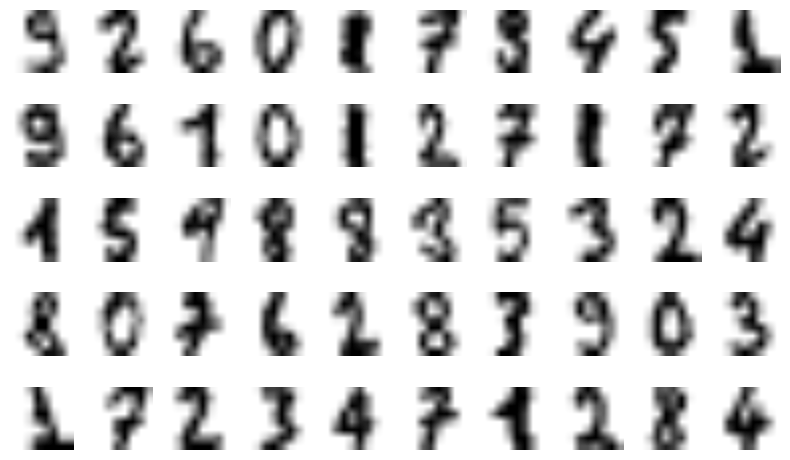

In [31]:
# Plot representative images
plt.figure(figsize=(8, 5))
for index, digit_image in enumerate(X_representative_digit):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(digit_image.reshape(8, 8), cmap='binary', interpolation='bilinear')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Get representative samples labels (the semi-supervised part)

In [53]:
y_representative_digit = y_train[representative_digit_idx]
pd.DataFrame(y_train).value_counts()

0
1    145
2    139
7    138
3    137
8    136
6    136
0    135
9    132
4    126
5    123
Name: count, dtype: int64

### Train a classifier using only the representative samples

In [33]:
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)
log_reg.fit(X_representative_digit, y_representative_digit)
log_reg.score(X_test, y_test)

c:\Users\AFRAAD-PC1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.9133333333333333

## DBSCAN

In [34]:
from sklearn.cluster import DBSCAN

dbsacn = DBSCAN(eps=0.05, min_samples=5)
dbsacn.fit(cleaned_data)

pd.DataFrame(dbsacn.labels_).value_counts()

0 
-1    32556
 0        5
Name: count, dtype: int64

In [35]:
pd.DataFrame(dbsacn.labels_).value_counts()

0 
-1    32556
 0        5
Name: count, dtype: int64